In [133]:
%matplotlib inline


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import os
import pandas as pd
import re
from collections import Counter
from multiprocessing import Pool
from plotting_utils import label_sample, figure_path
from sequencing_tools.viz_tools import color_encoder, simpsons_palette, okabeito_palette


def smallRNA():
    bed = '/stor/work/Lambowitz/ref/hg19_ref/genes/smallRNA.bed'
    with open(bed) as b:
        RNA_length = {l.split('\t')[0]:int(l.split('\t')[2])for l in b}
    return RNA_length


def read_R2_bed(sample_folder):
    bed = pd.read_table(sample_folder + '/smallRNA/r2_annotated_antisense.bed',
                   usecols = [0,1,2,6],
                   names = ['RNA','start','end','R2_contam'])\
        .assign(fulllength = lambda d: d.RNA.map(smallRNA())) \
        .query('fulllength == end') \
        .assign(with_R2 = lambda d: np.where(d.R2_contam > 3, 'with R2','No R2'))\
        .assign(sample = os.path.basename(sample_folder))
    return bed

def collect_antisense(sample_folder):
    bed = sample_folder + '/smallRNA/aligned.bed'
    strand_counter = Counter()
    with open(bed) as infile:
        for line in infile:
            strand = line.strip().split('\t')[5]
            strand_counter[strand] += 1
    return (os.path.basename(sample_folder), strand_counter['+'], strand_counter['-'])

In [131]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
sample_folders = glob.glob(project_path + '/*001')
sample_folders = filter(lambda x: re.search('[Q][cC][fF]', os.path.basename(x)), sample_folders)
sample_folders = list(sample_folders)
df = map(read_R2_bed, sample_folders)
df = pd.concat(df, sort=False) \
    .assign(prep = lambda d: d['sample'].map(label_sample))
df.head()

,RNA,start,end,R2_contam,fulllength,with_R2,sample,prep
28,hsa-mir-598,59,97,0,97,No R2,Qcf_Phos2_R1_001,DNase I + Phosphatase
47,TRG-TCC-3-1,9,76,4,76,with R2,Qcf_Phos2_R1_001,DNase I + Phosphatase
66,TRG-GCC-2-1,0,75,4,75,with R2,Qcf_Phos2_R1_001,DNase I + Phosphatase
100,TRV-CAC-5-1,0,78,0,78,No R2,Qcf_Phos2_R1_001,DNase I + Phosphatase
106,TRG-TCC-1-1,0,76,0,76,No R2,Qcf_Phos2_R1_001,DNase I + Phosphatase


In [121]:
full_length = df\
    .groupby(['sample','prep','with_R2'], as_index=False)\
    .agg({'R2_contam':'count'}) \
    .pipe(pd.pivot_table, index=['sample','prep'], 
          columns = 'with_R2', values='R2_contam') \
    .reset_index()\
    .assign(R2_rate = lambda d: 100 * d['with R2']/(d['No R2'] + d['with R2']))
full_length.head()

with_R2,sample,prep,No R2,with R2,R2_rate
0,QCF1_R1_001,DNase I,415.0,417.0,50.120192
1,QCF2_R1_001,DNase I,387.0,411.0,51.503759
2,Qcf10_R1_001,DNase I,84.0,99.0,54.098361
3,Qcf11_R1_001,DNase I,81.0,127.0,61.057692
4,Qcf12_R1_001,DNase I,307.0,262.0,46.045694


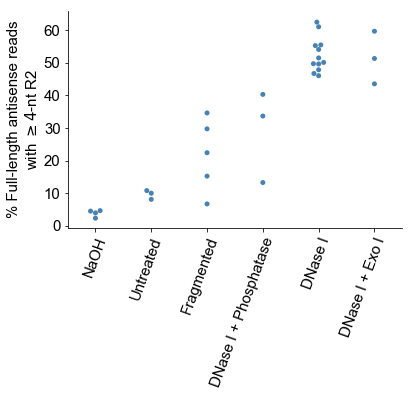

In [153]:
order_df = full_length \
    .pipe(lambda d: d[~pd.isnull(d.R2_rate)])\
    .groupby('prep', as_index=False)\
    .agg({'R2_rate':'median'})\
    .sort_values('R2_rate')

ax = plt.subplot(111)
sns.swarmplot(data = full_length,
             x = 'prep',
             y = 'R2_rate',
             order = order_df['prep'],
             color = 'steelblue')
xts = ax.set_xticklabels(ax.get_xticklabels(), rotation=70, rotation_mode = 'anchor', ha='right')
ax.set_ylabel('% Full-length antisense reads\nwith $\geq 4$-nt R2')
ax.set_xlabel('')
sns.despine()
plt.savefig(figure_path + '/recopy_rate.pdf', bbox_inches='tight')

In [123]:
cum_df = df\
    .groupby(['R2_contam','sample','prep'], as_index=False)\
    .agg({'with_R2':'count'})  \
    .sort_values('R2_contam')\
    .assign(with_R2_cum = lambda d: d.groupby(['sample'])['with_R2'].cumsum())\
    .assign(cum_frac = lambda d: d.groupby(['sample']).with_R2_cum.transform(lambda x: x/x.max()))\
    .sort_values(['sample','R2_contam'])  \
    .pipe(lambda d: d[d.prep.isin(d \
                            .query('R2_contam >  0')\
                            .groupby('prep', as_index=False)\
                            .agg({'with_R2':'max'})\
                            .query('with_R2 > 0')\
                            .prep)])
cum_df.head()

,R2_contam,sample,prep,with_R2,with_R2_cum,cum_frac
0,0,QCF1_R1_001,DNase I,415,415,0.498798
36,4,QCF1_R1_001,DNase I,222,637,0.765625
71,6,QCF1_R1_001,DNase I,7,644,0.774038
81,7,QCF1_R1_001,DNase I,5,649,0.780048
88,8,QCF1_R1_001,DNase I,89,738,0.887019


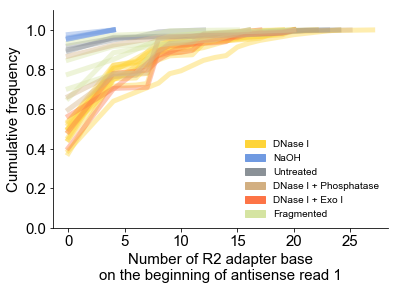

In [157]:
ax = plt.subplot(111)
sample_encoder = color_encoder()
sample_encoder.fit(cum_df.prep, simpsons_palette())
for (s, p), s_df in cum_df.groupby(['sample','prep']):
    x = s_df.R2_contam
    y = s_df.cum_frac
    color =  sample_encoder.encoder[p]
    ax.plot(x, y , color = color, alpha=0.4, linewidth=5)
sample_encoder.show_legend(ax, frameon=False)
ax.set_xlabel('Number of R2 adapter base\non the beginning of antisense read 1')
ax.set_ylabel('Cumulative frequency')
ax.set_ylim(0,1.1)
sns.despine()
plt.savefig(figure_path + '/recopy_cumdist.pdf', bbox_inches = 'tight')

In [144]:
p = Pool(24)
res = p.map(collect_antisense, sample_folders)
p.close()
p.join()

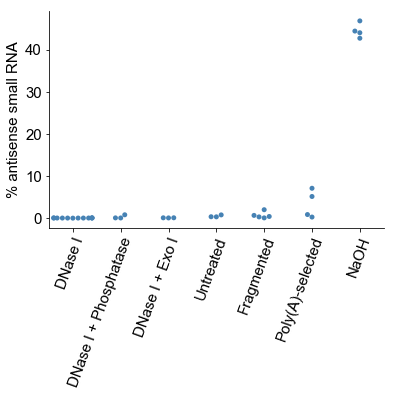

In [156]:
anti_df = pd.DataFrame(res, columns=['sample','plus_strand','neg_strand'])\
    .assign(anti_rate = lambda d: 100 * d.neg_strand/(d.neg_strand + d.plus_strand))\
    .assign(prep = lambda d: d['sample'].map(label_sample)) 

order_df = anti_df \
    .groupby('prep', as_index=False)\
    .agg({'anti_rate':'median'})\
    .sort_values('anti_rate')\
    .pipe(lambda d: d[~d.prep.str.contains('High')])

ax = plt.subplot()
sns.swarmplot(data = anti_df, 
    x = 'prep', 
    y = 'anti_rate',   
    color = 'steelblue', 
    order = order_df.prep,
    ax = ax)
xts = ax.set_xticklabels(ax.get_xticklabels(), rotation=70, rotation_mode = 'anchor', ha='right')
ax.set_xlabel('')
ax.set_ylabel('% antisense small RNA')
sns.despine()
plt.savefig(figure_path + '/recopy_antisense.pdf', bbox_inches = 'tight')

In [152]:
anti_df.groupby('prep').agg({'anti_rate':['min','max','mean','median']})

anti_rate                                 
                             min        max       mean     median
prep                                                             
DNase I                 0.011199   0.081064   0.043056   0.041160
DNase I + Exo I         0.062246   0.095049   0.081962   0.088593
DNase I + Phosphatase   0.055276   0.808393   0.312169   0.072838
Fragmented              0.071501   2.012979   0.691542   0.405641
High salt (450mM)       0.017491   0.036596   0.028462   0.031300
NaOH                   42.764502  46.884833  44.547317  44.269967
Poly(A)-selected        0.270023   7.109635   3.350278   3.010728
Untreated               0.320954   0.783318   0.482730   0.343917